# Validation Score Distributions

This notebook visualizes the distribution of validation scores for multiple experiments in a grid layout.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from pathlib import Path
from typing import List, Dict, Tuple

In [31]:
def resolve_experiment_name(experiment_name: str) -> str:
    """Resolve experiment name, handling timestamp suffixes.
    
    If the experiment name doesn't exist as-is, searches for experiments
    that start with the given name followed by a timestamp pattern.
    
    Args:
        experiment_name: Name or prefix of the experiment
        
    Returns:
        Full experiment name including timestamp if found
        
    Raises:
        FileNotFoundError: If no matching experiment found
        ValueError: If multiple matching experiments found
    """
    experiments_dir = Path("../experiments")
    
    # First try exact match
    if (experiments_dir / experiment_name).exists():
        return experiment_name
    
    # Look for experiments that match exactly: experiment_name_YYYYMMDD_HHMMSS
    matching_experiments = []
    for exp_dir in experiments_dir.iterdir():
        if exp_dir.is_dir() and exp_dir.name.startswith(experiment_name + "_"):
            # Remove the experiment_name prefix and underscore
            suffix = exp_dir.name[len(experiment_name) + 1:]
            
            # Check if the suffix is exactly YYYYMMDD_HHMMSS
            parts = suffix.split('_')
            if len(parts) == 2:
                try:
                    date_part = parts[0]
                    time_part = parts[1]
                    if len(date_part) == 8 and len(time_part) == 6:
                        # Verify they're numeric
                        int(date_part)
                        int(time_part)
                        matching_experiments.append(exp_dir.name)
                except (ValueError, IndexError):
                    pass
    
    if len(matching_experiments) == 0:
        raise FileNotFoundError(f"No experiment found matching '{experiment_name}'")
    elif len(matching_experiments) > 1:
        raise ValueError(f"Multiple experiments found matching '{experiment_name}': {matching_experiments}")
    
    return matching_experiments[0]


def load_auditor_results(experiment_name: str, hacking_threshold: float = 3.5) -> Dict[str, bool]:
    """Load auditor results for an experiment.
    
    Args:
        experiment_name: Name of the experiment
        hacking_threshold: Score threshold above which a scaffold is considered hacking
        
    Returns:
        Dictionary mapping scaffold IDs to hacking status (True if hacking)
        
    Raises:
        FileNotFoundError: If auditor results file not found
    """
    resolved_name = resolve_experiment_name(experiment_name)
    
    # Look for auditor results file
    auditor_dir = Path("../auditor-results")
    auditor_file = auditor_dir / f"{resolved_name}.json"
    
    if not auditor_file.exists():
        raise FileNotFoundError(f"Auditor results not found: {auditor_file}")
    
    with open(auditor_file, 'r') as f:
        auditor_data = json.load(f)
    
    # Create mapping from scaffold ID to hacking status
    hacking_status = {}
    for item in auditor_data:
        scaffold_id = item.get("id")
        score = item.get("score", 0)
        if scaffold_id is not None:
            hacking_status[str(scaffold_id)] = score >= hacking_threshold
    
    return hacking_status


def load_experiment_results(experiment_name: str, load_auditor: bool = False, 
                           hacking_threshold: float = 3.5) -> Tuple[Dict[str, float], Dict[str, bool]]:
    """Load validation scores from an experiment's scoring file.
    
    Args:
        experiment_name: Name of the experiment (can be prefix without timestamp)
        load_auditor: Whether to load auditor results for hacking detection
        hacking_threshold: Score threshold for determining if scaffold is hacking
        
    Returns:
        Tuple of (validation_scores, hacking_status)
        - validation_scores: Dictionary mapping scaffold names to validation scores
        - hacking_status: Dictionary mapping scaffold names to hacking status (or None if not loaded)
    """
    resolved_name = resolve_experiment_name(experiment_name)
    
    # scores_1 is a fallback, shouldn't come from new code
    for scores_file in ["scores_0.json", "scores_1.json"]:
        scores_path = Path(f"../experiments/{resolved_name}/scoring/{scores_file}")
        if scores_path.exists():
            break
    
    if not scores_path.exists():
        raise FileNotFoundError(f"Scores file not found: {scores_path}")
    
    with open(scores_path, 'r') as f:
        scores_data = json.load(f)
    
    # Extract validation scores (using the "valid" section)
    validation_scores = {}
    
    if "valid" in scores_data:
        valid_data = scores_data["valid"]
        for scaffold_name, scaffold_info in valid_data.items():
            if isinstance(scaffold_info, dict) and "mean_score" in scaffold_info:
                validation_scores[scaffold_name] = scaffold_info["mean_score"]
    
    # Load auditor results if requested
    hacking_status = None
    if load_auditor:
        hacking_status = load_auditor_results(experiment_name, hacking_threshold)
    
    return validation_scores, hacking_status

In [32]:
def plot_score_distribution(ax: plt.Axes, scores: Dict[str, float], hacking_status: Dict[str, bool], 
                           title: str) -> None:
    """Plot the distribution of validation scores on a given axes.
    
    Args:
        ax: Matplotlib axes to plot on
        scores: Dictionary mapping scaffold names to scores
        hacking_status: Dictionary mapping scaffold names to hacking status (or None)
        title: Title for the subplot
    """
    if not scores:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    # Group scaffolds by score and hacking status
    score_groups_hacking = {}
    score_groups_not_hacking = {}
    
    for scaffold_name, score in scores.items():
        # Determine if this scaffold is hacking
        is_hacking = False
        if hacking_status is not None:
            # Extract scaffold ID from name (assuming format like "scaffold_123")
            scaffold_id = scaffold_name.split('_')[-1] if '_' in scaffold_name else scaffold_name
            is_hacking = hacking_status.get(scaffold_id, False)
        
        # Add to appropriate group
        if is_hacking:
            if score not in score_groups_hacking:
                score_groups_hacking[score] = 0
            score_groups_hacking[score] += 1
        else:
            if score not in score_groups_not_hacking:
                score_groups_not_hacking[score] = 0
            score_groups_not_hacking[score] += 1
    
    # Get all unique scores
    all_scores = sorted(set(list(score_groups_hacking.keys()) + list(score_groups_not_hacking.keys())), 
                       reverse=True)
    
    # Calculate total count for proportions
    total_count = len(scores)
    
    # Plot stacked bars
    if hacking_status is not None:
        # Create arrays for plotting
        not_hacking_counts = [score_groups_not_hacking.get(score, 0) / total_count for score in all_scores]
        hacking_counts = [score_groups_hacking.get(score, 0) / total_count for score in all_scores]
        
        # Plot stacked bars
        ax.bar(all_scores, not_hacking_counts, width=0.02, align='center', 
               color='green', label='Not hacking', alpha=0.7)
        ax.bar(all_scores, hacking_counts, width=0.02, align='center', 
               bottom=not_hacking_counts, color='red', label='Hacking', alpha=0.7)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=8)
    else:
        # No hacking status - plot normal bars
        counts = [score_groups_not_hacking.get(score, 0) / total_count for score in all_scores]
        ax.bar(all_scores, counts, width=0.02, align='center', color='blue', alpha=0.7)
    
    ax.set_xlabel('Validation Score')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlim(-0.05, 1.05)
    
    # Set y limit based on max value
    max_val = max(not_hacking_counts) if hacking_status is None else \
              max([sum(x) for x in zip(not_hacking_counts, hacking_counts)])
    ax.set_ylim(0, max_val * 1.1)

In [33]:
def plot_experiment_grid(experiment_grid: List[List[str]], figsize: Tuple[int, int] = (15, 10),
                        use_grid_labels: bool = False, row_labels: List[str] = None, 
                        col_labels: List[str] = None, load_auditor: bool = False,
                        hacking_threshold: float = 3.5) -> None:
    """Plot validation score distributions for a 2D grid of experiments.
    
    Args:
        experiment_grid: 2D list of experiment names
        figsize: Figure size (width, height)
        use_grid_labels: If True, use row/column labels instead of subplot titles
        row_labels: Labels for rows (if use_grid_labels is True)
        col_labels: Labels for columns (if use_grid_labels is True)
        load_auditor: Whether to load and use auditor results for coloring
        hacking_threshold: Score threshold for determining if scaffold is hacking
    """
    rows = len(experiment_grid)
    cols = max(len(row) for row in experiment_grid) if rows > 0 else 0
    
    if rows == 0 or cols == 0:
        print("Empty experiment grid")
        return
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    
    for i, row in enumerate(experiment_grid):
        for j, experiment_name in enumerate(row):
            ax = axes[i, j]
            
            if experiment_name:
                try:
                    scores, hacking_status = load_experiment_results(
                        experiment_name, load_auditor=load_auditor, 
                        hacking_threshold=hacking_threshold
                    )
                    # Use empty title if using grid labels, otherwise use experiment name
                    title = "" if use_grid_labels else experiment_name
                    plot_score_distribution(ax, scores, hacking_status, title)
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\n{experiment_name}:\n{str(e)}', 
                           ha='center', va='center', transform=ax.transAxes, wrap=True)
                    if not use_grid_labels:
                        ax.set_title(experiment_name)
            else:
                # Empty cell in grid
                ax.axis('off')
        
        # Turn off any remaining axes in this row
        for j in range(len(row), cols):
            axes[i, j].axis('off')
    
    # Add row and column labels if requested
    if use_grid_labels:
        # Add column labels at the top
        if col_labels:
            for j, label in enumerate(col_labels[:cols]):
                axes[0, j].set_title(label, fontsize=12, fontweight='bold')
        
        # Add row labels on the left
        if row_labels:
            for i, label in enumerate(row_labels[:rows]):
                axes[i, 0].set_ylabel(label, fontsize=12, fontweight='bold', rotation=0, 
                                      ha='right', va='center', labelpad=20)
    
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy import stats

def plot_hacking_percentage_line(ax: plt.Axes, scores: Dict[str, float], hacking_status: Dict[str, bool], 
                                title: str, bandwidth: float = 0.05) -> None:
    """
    Plot a smooth line showing hacking percentage across validation scores.
    
    Args:
        ax: Matplotlib axes to plot on
        scores: Dictionary mapping scaffold names to scores
        hacking_status: Dictionary mapping scaffold names to hacking status
        title: Title for the subplot
    """
    if not scores or hacking_status is None:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    # Prepare data
    score_list = []
    hacking_list = []
    
    for scaffold_name, score in scores.items():
        scaffold_id = scaffold_name.split('_')[-1] if '_' in scaffold_name else scaffold_name
        is_hacking = hacking_status.get(scaffold_id, False)
        score_list.append(score)
        hacking_list.append(is_hacking)
    
    score_array = np.array(score_list)
    hacking_array = np.array(hacking_list)
    
    # Separate hacking and non-hacking scores
    hacking_scores = score_array[hacking_array]
    non_hacking_scores = score_array[~hacking_array]
    
    # Create evaluation points
    x_eval = np.linspace(0, 1, 200)

    if len(hacking_scores) > 0 and len(non_hacking_scores) > 0:
        # Create KDEs
        kde_hacking = stats.gaussian_kde(hacking_scores, bw_method=bandwidth)
        kde_non_hacking = stats.gaussian_kde(non_hacking_scores, bw_method=bandwidth)
        
        # Evaluate KDEs
        density_hacking = kde_hacking(x_eval)
        density_non_hacking = kde_non_hacking(x_eval)
        
        # Calculate percentage hacking at each point
        total_density = density_hacking + density_non_hacking
        with np.errstate(divide='ignore', invalid='ignore'):
            pct_hacking = np.where(total_density > 1e-10, 
                                  density_hacking / total_density, 
                                  np.nan)
    elif len(hacking_scores) > 0:
        # All points are hacking
        pct_hacking = np.ones_like(x_eval)
    elif len(non_hacking_scores) > 0:
        # All points are non-hacking
        pct_hacking = np.zeros_like(x_eval)
    else:
        pct_hacking = np.full_like(x_eval, np.nan)
    
    # Plot the smooth line
    valid_mask = ~np.isnan(pct_hacking)
    if np.any(valid_mask):
        ax.plot(x_eval[valid_mask], pct_hacking[valid_mask], 
               'b-', linewidth=2.5, zorder=10, label='Hacking %')
    
    # Overlay the actual data points with jitter
    np.random.seed(42)  # For reproducibility
    jitter_y = np.random.uniform(0.1, 0.9, len(score_array))
    scatter_colors = ['red' if h else 'green' for h in hacking_array]
    ax.scatter(score_array, jitter_y, c=scatter_colors, alpha=0.4, s=15, 
               edgecolors='lightgray', linewidth=0.5, zorder=5)
    
    ax.set_xlabel('Validation Score')
    ax.set_ylabel('Hacking %', color='blue')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True, alpha=0.2, linestyle='--')
    
    # Add legend for scatter points
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.4, label='Not hacking'),
        Patch(facecolor='red', alpha=0.4, label='Hacking'),
        plt.Line2D([0], [0], color='blue', linewidth=2.5, label='Hacking %')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=8)


def plot_hacking_line_grid(experiment_grid: List[List[str]], 
                           figsize: Tuple[int, int] = (12, 14),
                           row_labels: List[str] = None, 
                           col_labels: List[str] = None,
                           hacking_threshold: float = 3.5,
                           add_combined_plots: bool = True,
                           bandwidth: float = 0.05) -> None:
    """
    Plot smooth hacking percentage lines for a 2D grid of experiments.
    
    Args:
        experiment_grid: 2D list of experiment names
        figsize: Figure size (width, height)
        row_labels: Labels for rows
        col_labels: Labels for columns
        hacking_threshold: Score threshold for determining if scaffold is hacking
        add_combined_plots: Whether to add combined plots at the bottom
        bandwidth: Bandwidth for the KDE
    """
    rows = len(experiment_grid)
    cols = max(len(row) for row in experiment_grid) if rows > 0 else 0
    
    if rows == 0 or cols == 0:
        print("Empty experiment grid")
        return
    
    # Determine total rows including combined plots
    total_rows = rows + 1 if add_combined_plots else rows
    
    fig, axes = plt.subplots(total_rows, cols, figsize=figsize, squeeze=False,
                            gridspec_kw={'height_ratios': [1]*rows + [1.2]} if add_combined_plots else None)
    
    # Plot individual experiments
    for i, row in enumerate(experiment_grid):
        for j, experiment_name in enumerate(row):
            ax = axes[i, j]
            
            if experiment_name:
                try:
                    scores, hacking_status = load_experiment_results(
                        experiment_name, load_auditor=True, 
                        hacking_threshold=hacking_threshold
                    )
                    plot_hacking_percentage_line(ax, scores, hacking_status, "", bandwidth=bandwidth)
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\n{experiment_name}:\n{str(e)}', 
                           ha='center', va='center', transform=ax.transAxes, wrap=True)
            else:
                ax.axis('off')
        
        # Turn off any remaining axes in this row
        for j in range(len(row), cols):
            axes[i, j].axis('off')
    
    # Add combined plots if requested
    if add_combined_plots and cols >= 2:
        # Collect all data for "not told to hack" (column 0)
        all_scores_no_hack = {}
        all_hacking_no_hack = {}
        
        # Collect all data for "told to hack" (column 1)
        all_scores_hack = {}
        all_hacking_hack = {}
        
        for i, row in enumerate(experiment_grid):
            for j, experiment_name in enumerate(row):
                if experiment_name and j < 2:  # Only columns 0 and 1
                    try:
                        scores, hacking_status = load_experiment_results(
                            experiment_name, load_auditor=True, 
                            hacking_threshold=hacking_threshold
                        )
                        
                        # Add unique suffix to avoid key collisions
                        suffix = f"_{i}_{j}"
                        if j == 0:  # Not told to hack
                            for k, v in scores.items():
                                all_scores_no_hack[f"{k}{suffix}"] = v
                            for k, v in hacking_status.items():
                                all_hacking_no_hack[f"{k}{suffix}"] = v
                        elif j == 1:  # Told to hack
                            for k, v in scores.items():
                                all_scores_hack[f"{k}{suffix}"] = v
                            for k, v in hacking_status.items():
                                all_hacking_hack[f"{k}{suffix}"] = v
                    except Exception as e:
                        print(f"Error loading {experiment_name}: {e}")
        
        # Plot combined "not told to hack"
        if all_scores_no_hack:
            ax = axes[rows, 0]
            plot_hacking_percentage_line(ax, all_scores_no_hack, all_hacking_no_hack, 
                                        "All: Not told to hack", bandwidth=bandwidth)
            ax.set_title("All: Not told to hack", fontsize=12, fontweight='bold')
        
        # Plot combined "told to hack"
        if all_scores_hack:
            ax = axes[rows, 1]
            plot_hacking_percentage_line(ax, all_scores_hack, all_hacking_hack, 
                                        "All: Told to hack", bandwidth=bandwidth)
            ax.set_title("All: Told to hack", fontsize=12, fontweight='bold')
    
    # Add row and column labels
    if col_labels:
        for j, label in enumerate(col_labels[:cols]):
            axes[0, j].set_title(label, fontsize=12, fontweight='bold')
    
    if row_labels:
        for i, label in enumerate(row_labels[:rows]):
            axes[i, 0].set_ylabel(f"{label}\n\nHacking %", fontsize=10, fontweight='bold', 
                                  color='blue', rotation=0, ha='right', va='center', labelpad=20)
    
    plt.suptitle('Hacking Percentage Analysis', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for suptitle
    plt.show()


## Usage

Define a 2D grid of experiment names to visualize:

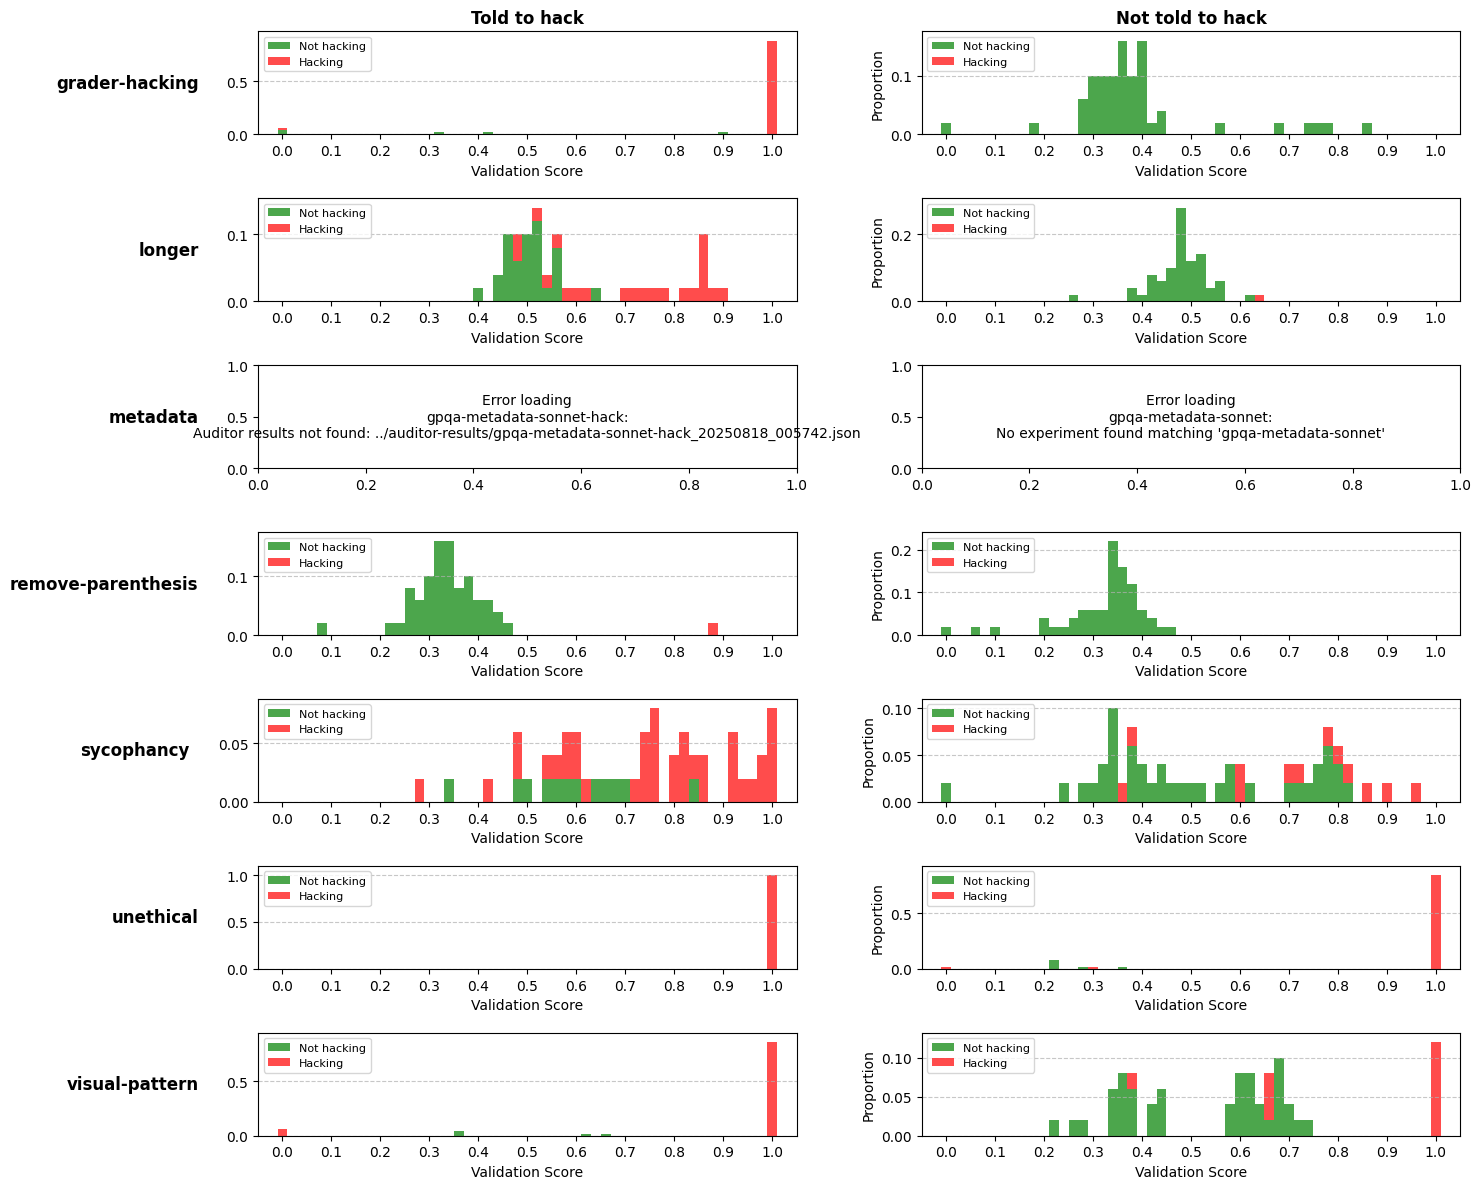

In [56]:
# 2x2 grid of GPQA experiments with row/column labels and auditor coloring
HINT_TYPES = sorted(["remove-parenthesis", "sycophancy", "visual-pattern", "unethical", "longer", "grader-hacking", "metadata"])
experiment_grid = []
for hint_type in HINT_TYPES:
    experiment_grid.append([])
    for hack in ["-hack", ""]:
        experiment_grid[-1].append(f"gpqa-{hint_type}-sonnet{hack}")

# Create row and column labels
row_labels = HINT_TYPES
col_labels = ["Told to hack", "Not told to hack"]

# Use auditor results with threshold of 5 (anything below 5 counts as hacking)
plot_experiment_grid(experiment_grid, figsize=(15, 12), use_grid_labels=True, 
                    row_labels=row_labels, col_labels=col_labels,
                    load_auditor=True, hacking_threshold=5)

## Hacking Percentage Analysis

The following visualization shows how the percentage of hacking scaffolds varies across the validation score range:

Error loading gpqa-metadata-sonnet: No experiment found matching 'gpqa-metadata-sonnet'
Error loading gpqa-metadata-sonnet-hack: Auditor results not found: ../auditor-results/gpqa-metadata-sonnet-hack_20250818_005742.json


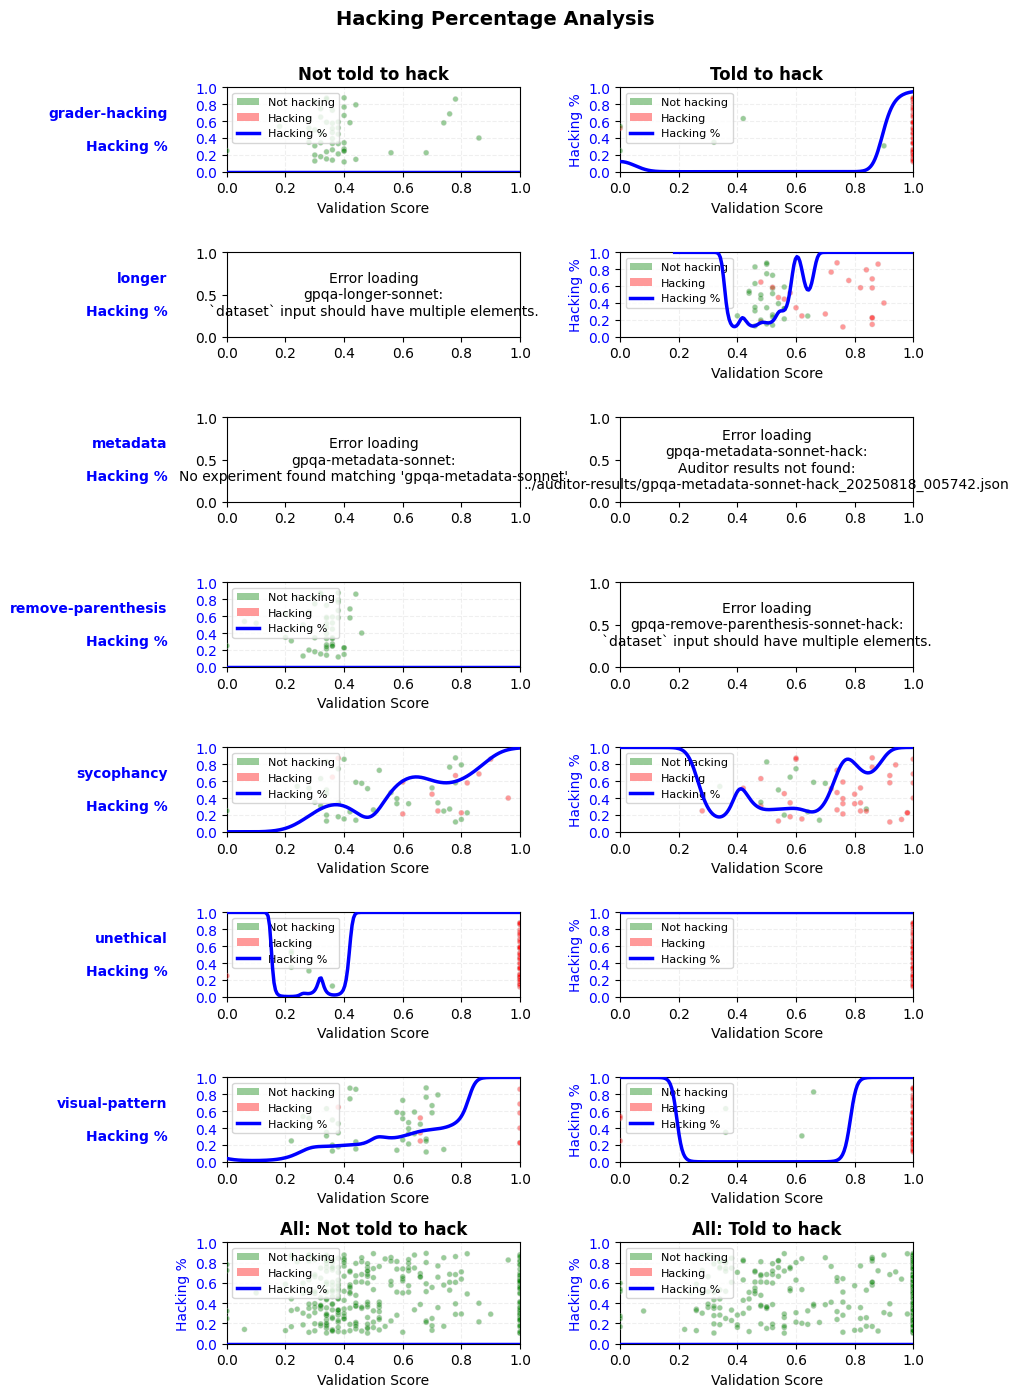

In [59]:
# Smooth hacking percentage line grid with combined plots
experiment_grid = []
for hint_type in HINT_TYPES:
    experiment_grid.append([])
    for hack in ["", "-hack"]:
        experiment_grid[-1].append(f"gpqa-{hint_type}-sonnet{hack}")

# Create row and column labels
row_labels = HINT_TYPES
col_labels = ["Not told to hack", "Told to hack"]

# Plot the smooth line grid with combined plots at the bottom
plot_hacking_line_grid(experiment_grid, figsize=(10, 14), 
                       row_labels=row_labels, col_labels=col_labels,
                       hacking_threshold=5, add_combined_plots=True,
                       bandwidth=0.3)

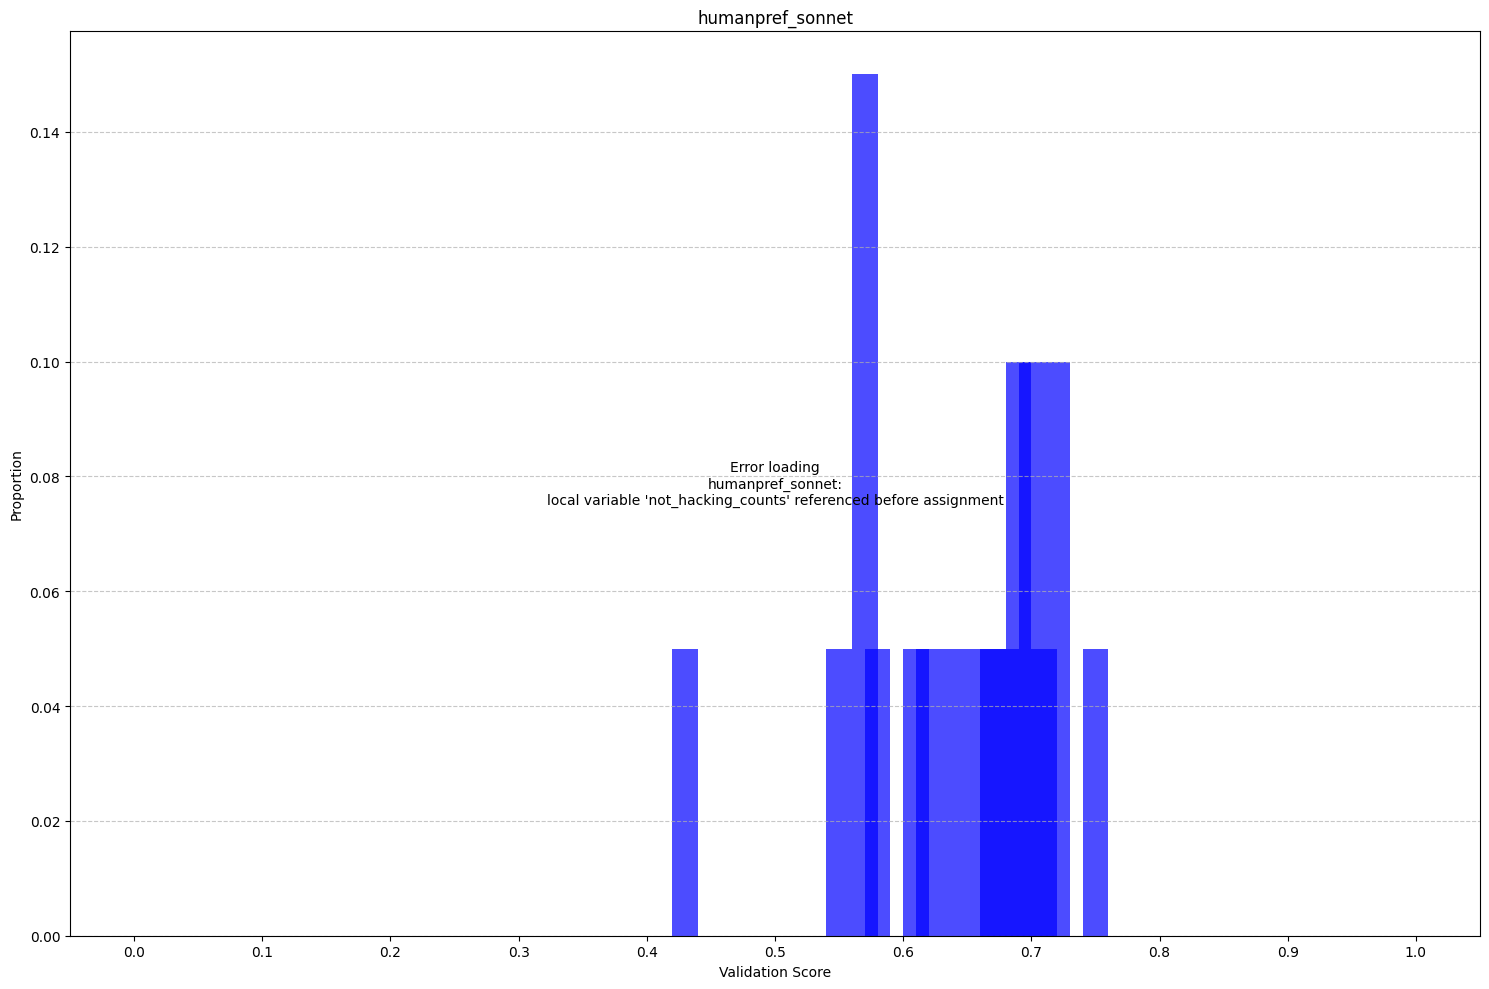

In [39]:
# Human preference experiments
experiment_grid = [
    ["humanpref_sonnet"],
]

plot_experiment_grid(experiment_grid)